# KFServing samples

In [ ]:
!pip install --upgrade pip
!pip install kfp

## 1. KFServing

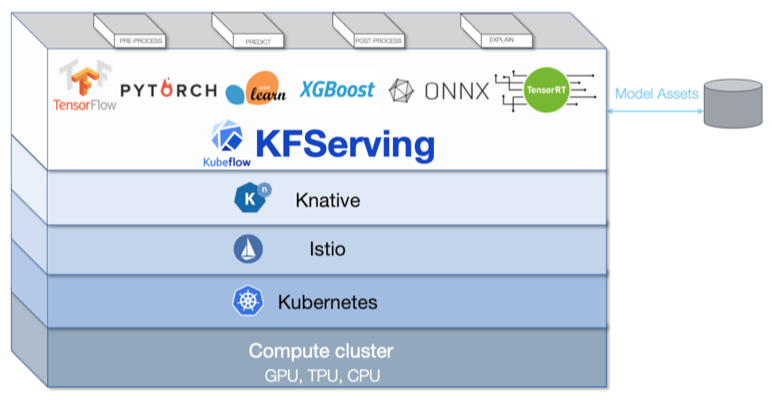


## 1. KFServing with kubectl

Our first example will use a [sklearn model](https://github.com/kubeflow/kfserving/tree/master/docs/samples/sklearn) trained with the [iris](https://archive.ics.uci.edu/ml/datasets/iris) dataset. This dataset has 3 output classes: (Iris Setosa, Iris Versicolour, and Iris Virginica)

Then, we serve our model using the KFServing platform by running kubectl.


In [ ]:
## Initial cluster variables
## Update the kubeflow_url to your Kubeflow dashboard endpoint if it's running on a remote cluster.

import os

# use internal ingressgateway path or external ingress url
kubeflow_url = 'istio-ingressgateway.istio-system'

os.environ["kubeflow_url"] = kubeflow_url

# retrieve the cookie session through your browser or command line
# refer to https://github.com/kubeflow/kfserving/tree/master/docs/samples/istio-dex
session = "xxxxxxxx"

Next, we need to define the Kubernetes yaml for deploying this model.

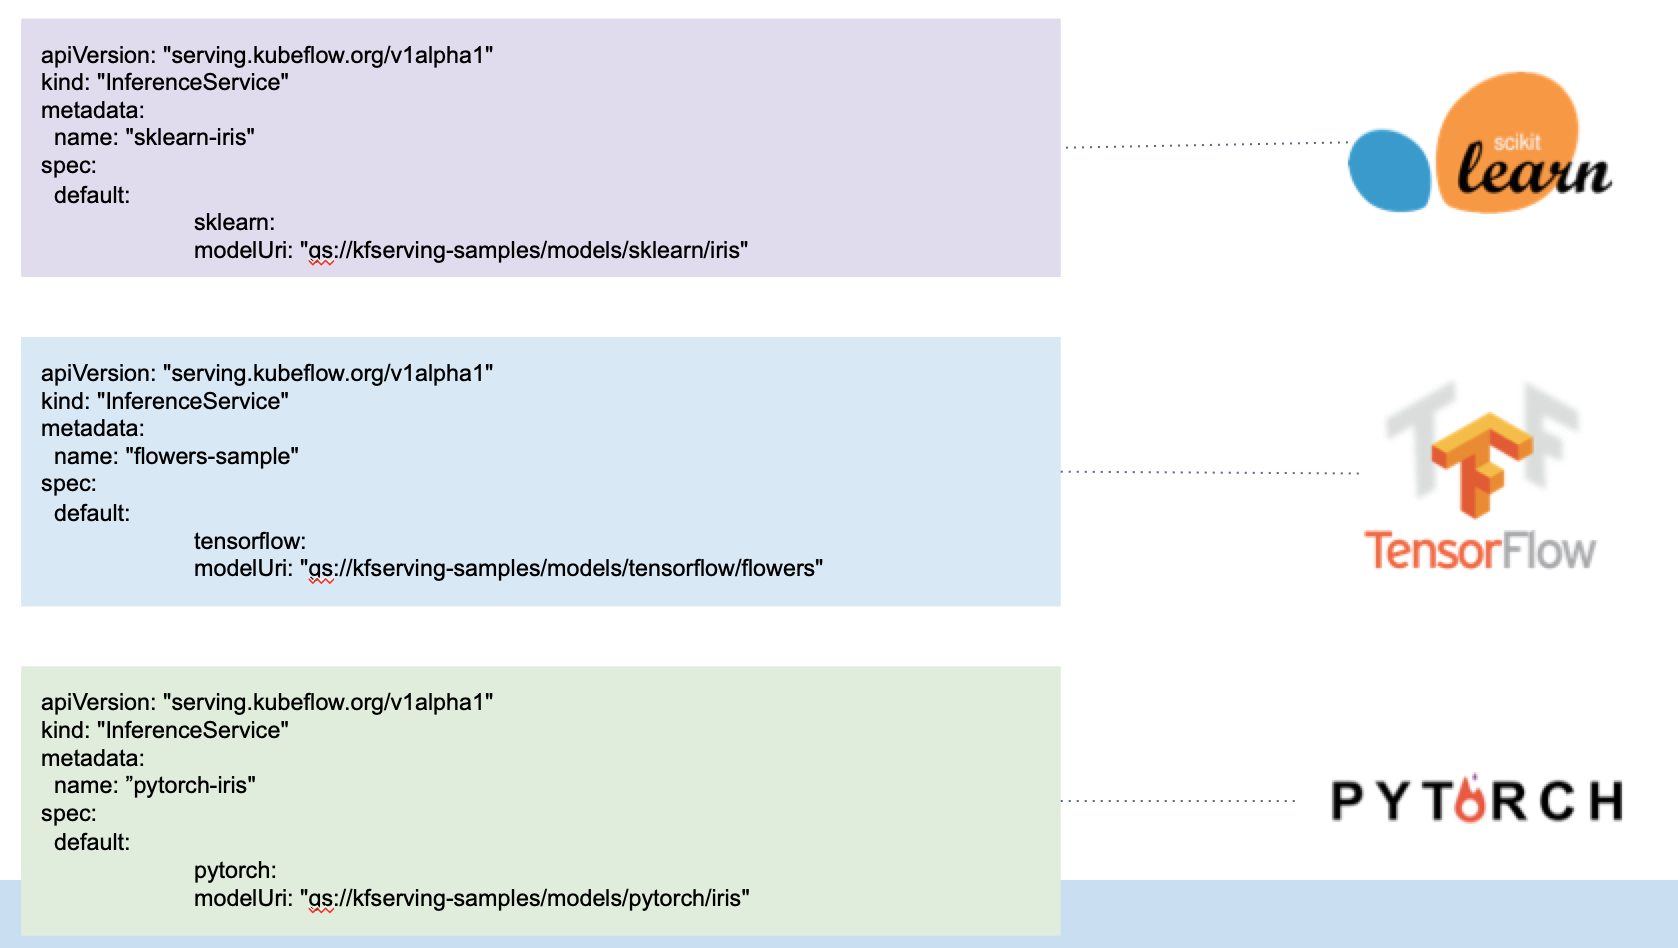

In [ ]:
# sidecar injection annotations is required for multi-user

import textwrap
sklearn_yaml = textwrap.dedent("""\
apiVersion: "serving.kubeflow.org/v1alpha2"
kind: "InferenceService"
metadata:
  name: "sklearn-iris"
  annotations:
    sidecar.istio.io/inject: "false"
spec:
  default:
    predictor:
      sklearn:
        storageUri: "gs://kfserving-samples/models/sklearn/iris"
""")
f = open("sklearn.yaml", "w")
f.write(sklearn_yaml)
f.close()

In [ ]:
!kubectl apply -f sklearn.yaml

In [ ]:
!kubectl get pod | grep sklearn-iris
!kubectl get inferenceservice sklearn-iris

Once the model is ready, we then can do model prediction using a simple curl command.

In [ ]:
%%bash
MODEL_NAME=sklearn-iris
SERVICE_HOSTNAME=$(kubectl get inferenceservice sklearn-iris -o jsonpath='{.status.url}' | cut -d "/" -f 3)
echo $SERVICE_HOSTNAME

# retrieve the cookie session through your browser or command line
# refer to https://github.com/kubeflow/kfserving/tree/master/docs/samples/istio-dex
SESSION=xxxxxxxx
curl -v -H "Host: ${SERVICE_HOSTNAME}"  -H "Cookie: authservice_session=${SESSION}" http://$kubeflow_url/v1/models/$MODEL_NAME:predict -d '{"instances": [[6.8,  2.8,  4.8,  1.4],[6.0,  3.4,  4.5,  1.6]]}'

In [ ]:
## clean up the previous examples
!kubectl delete inferenceservice --all

## 2. KFServing with Python SDK

### Install the necessary kfp and kfserving library

In [ ]:
# if running pipelines with kfp-tekton
# !pip install kfp-tekton --upgrade -q
!pip install kfserving --upgrade -q 
!pip install keras==2.2.5 -q
!pip install scikit-image -q

In [ ]:
## Initial variables and helper functions
import requests
from kfserving import utils

model_name = 'tf-flower'
namespace = utils.get_default_target_namespace()
tf_request = {  
            "instances":[  
            {  
                "image_bytes":{  
                    "b64":"/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAErASsDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwC9A42ir9vA0nOOKxYJhkDqe1bNvO0ZAYdaIsC8LLjOwH60yWDAwY1/75qzDcDAz0qfhl55BqxGE1pCzZwVPt0qJ7MgZQbh7da1Z7bncBVQgoaVhlGFvKlBIwOhqxPFxkdKmdY5xiQYP94daaqtGPKkO5P4X/pU2AoKMMQatWv+tAPXpTJ4ipyBTVYqwYHBFTezA1ivHNRsuRU1tOlymOBIOo9aVoyGNaCIEHanEEEMKXbg07BAx2NICXO5KrvwcVPEcDFRyD5qTYDYhuPuKnA4waitxmQj1FWGX9Ka2ArODzUXU5qxIM81AODzUtjGzHMfvVRcl6mmOMio4V3PSAtwjBUd60l+6DVCMAzH2q6D8v0qo7CIJ3xmsqQ8kmtC5YAVmyctntSbGRkDOT0qWMFyABUWNzD0q5EuxM9zQgJQAqgCkJxS9vemMasA3c8CpFPHNRBgBkinBvSpuBMGxRnPWo1561IOlMBQMEU2R8DFKW2rk1XdsmgCN+TmqskuHIqeUhVNZMkoZyckZqQILTi5UntzWtHMOVbpWQh2zCr6jIBpRGzUjl2jBPHY1chuSODyKx4pOzdKnVyh68VYjbDBlyvSq88G4bhVeG4Kkc8HrV3eGUEVQjLkUr+FRmQgYzV+aMODxzWdIpU0mMerh1wahdCpPvTN21gQamB3jB+qn1rOQDI5GjcMvBFbdvMt1FkfeHWsJhzU1pcG3nDZ4PWlGVgNd4+MigL8uKscMgdeVNRsAORVsRGFwc1G45qfKg/MM/U0jLG3RQPxNS2BCh2OG9DVxwM57GqxRQc8j9asp80I5zjiiIyu64zVdhxVtwMVVak2BUlOTUlumATTXXmpPux0r6AS2vLv7GrLNtFVbM/K596knbgGqT0AqXLZeqbgsRU8x96hJzgCk2A+JPmA61PA4mUSL9wk7fcetULtmEMdvGSJrltgI6hQMsfwH6kVqRIsUaqgAVQAAOwFUgEJ7UwDOc1Ky55/OmtgcCi4EZ6UqqSc0Hk4p46igB44pQaaM5NI7hVx3qkA2V8nHaoAdzE9hTZHOMd6ZczfZoQq/fNDArahcgAxLyf4iKzs0OxJ5696ZUDQP97NaVsdyg+1IPszHlFzU8SRg4jGB6VSQh3linp02mpQm5enNJs9aoBoynfirMFwVOD0qADjDUn3W9qANIsGGQeKqXCK3PekjlIOCeKfJyN1AGXIMZFNik6xscc5U+hqxMgbPrVFwVas2BezvXOMOPvCo2GD7UyOXOG/iHX3p8hGzdn6Vm0M0rG8ZLYxtzz8pp0lyx/iNZUMpzzVkturURKZGP8AEfzpRMw6Nmq5HvTMspz1pAaUVzzhjiptxjPmRnjuKyBNzzxU8NwUbDcqaXoBreYJU3L+VVn5zTEcRvkHKNUjcE4qZdwITyabK3yGpG4GaqzN+7qG9ALNicwn/eNE75UgU2zb/RQfc0krY4rS+gFZgcc0iKM+9Kc81FcI727QxnDyjbu9AepoWrAZpv8Apt7NqB5jA8mAeig/MfxOPyFa4HFQ20KW8KQxrhEUKB7VYXFWAvlkhSDx1PvUchwSAKlD7Uyep6CoS3UnrU9QGHg0DJ5xSb8mjdjvVAOZ9oqs75JOaJX3Hg1GBmmAKRuLt0Xms24lMshbt2qxezgDyEPuxqkxpNjImo4pGOOarmbk0gJvMINWIbp42BB6VBLC0Z9qjVsGjYDqrWVJ4w6n6j0qcxbh71ztndtbyBlPHcetdLayx3Me+Ns+o7irTuJkDRDvwaYVIODWg0IYc9agkgBGDTEUyCv0pwc4wac8ZTg9KjYFRSAil6ZxVOYZFXGPBBqpKKljIFJB61KzFlqJhTkbPBrO+oxysR0qwrkjk1Wxg1IoPBJ4PpSc7BYkOfU0zzHXvke9WNuFBHQ1A/BrKVRoaQm/dweDShyOOtRZB+tAPHNSq6HYv203/LNuh6VeVvkweq1ioxB+lacUm5Nw7jBrVTUoktEsp+SqNw2F4q1I3yCqM5yQKwchpF62Yi0/GkcHgmkh4gAoOSK1UxEfVuKdbKZH8zseF+nrTGO0qo6scVciXgYrWG1xDxwcUm/GQKc3FVS3J5qmwHmUkknoKYXJGaZuBzTd1JMB4PBzxUUkhPApWcnpTFUk1SAdGrOcVW1S/TTbbIwZW4Rff1rQXbEmSefSqC6bHPdNd3Q86U/dDfdQegFUBkWYurnlI2YseWPetSPSZW5llC+yjJrUVABjt6CnHihJICkulWqcsGf/AHjUwt4QMCGMD/cFSM4HWm+YKq4HO/aAww3NRuqtypxTNpFIMisrjFDFDg1ctbySCQSRsQf5/Wqm4MOaT6GlewHY2OrQXWFciOT0J4NaDRq68/nXBLIRwa0bTVLi2wBIWX0bmqU+4rHSSQcFW5HY1TkiKZBGRUtrq8NyNr8N6VaYJIvysCPar0YjGdMDOeKrSL6ng1pXFuUJxyDVCSMgH0qGMqMvao84NTOp61XYkHmspDRYXBxnpSFjG2DyKbEdwK96eR5ilT95elZSKRYglBHlseD0NJKpU4NUlk2nB6VcjlEq7HPzDofWsJTvox2KzcZojbccGnSrgkVCpIkFcdaorblJFg8VctHzlapBs1Ztf9bTw+K01CUS07dvaqMh3TqKulSSTjPHWqCgGdnzkKOtYLGxbDkZoxnEYqR4j5e4HPqKrwncAO2M1X1jVRp+lXFxn7inHu3QCu6E3JKzIaC1lF3qk+05jtgIh/vnlj+AwPzrXUYArnvB0LLoUMshJknZpXJ7kmuhLAZxXcpIgimYjPNVd3HWpJnLHFQgcYp81xjht7U4AGkGFpDPt4QZNaIQ9YiRnoPemng4Tk+tIFdzmRjj0p5dEHFWmAqRfxOeakyAOwquZ93Sk5PJouBM0uKjMrHpUeRn5qQydhRcB3Pc0vHrUYJanbT6UwMX6ikKelafA/gX8qRljPWJfwzScAMsxjNJtx9K0Ht42HykqffkVA8DpzjI9RzUOLQ7lXbijDdRU2zIppX3qRipJ0z1rQttQkj4Ylh655FZjLzQMryDRewHUwXyTphiDnof8aZcQYO5eRXPw3BQ5U4Na1tf5Xa3I9KtSuTYgkjK5x0qpIpwM9K2HRJlLIefSqEsRGR+lRJAUVcxuCO1WpDlROn4iqknTp0p1tPtYo3KNXJOdtGWlcllUMBIvRuv1oGVOD1FOWIiRIz91zgH0qS6VoNwaMgKeJQMgfWvExGK960TeMRpPmqMnD4796JIQsf7s5lGAQT61YeSOS8SFwFkH3WHRuKq6fFJdajMZ3aMRtgqByT269q4nUnJXb2KskMjUiIS7sl32hfTtWhaArIQ42kdaaY/7PvzG6+dFMSWfHC91+nvS2e+Sab7QORNsUZwG7jn0xmpc3a6FYnDpC4lDEl/4G6DtVa5UqRDEADKTj2Hqas3Nkz6hGZGxCFJLL/FzwKluIykkQgQtC53N3Kn0+maxUrNMvRoiEZWPapAJ71keItPkvdPYiNnjg+cQjOZT/8AW61uOY1cGUcryFzUgkZ0JVsDtXfDGWmm9kZuGhX0qJLXT4IACuyMfKe1WZJQFOKiKlSCWycfnUUjjua9ali41PhZk42EbLHNISFFM83nA5pVXPLV3Ql2IaDBf2FOykQycUySUIMDrVZi0h5NbJiJnuGc4WkVWP3qYo29OtSKrt34q0wHhgo4GaCx/CnLCw561OkJP8NWIrBd/apVtj3qysI74FSZjTimBElsO1S+QKQzf3cCk3v60AUiqEcVG0R7DNPIZT92kLY5yRWgFd0I7UwMyGrLHPYGoXQHkVLAYYUlGUwj/oarMhRyrqQam3FDU6yRzoEl7dG7ioaTAzyuR0phQ+tXJreSLn7yHow6GoNhas2h3K5UA5zSrIUI5qQx5qIoBwRUMZehvMEZbB7GrS3Mdy/lMQk3YH+L6HvWJnHHpSs0c0ZinBKeoOCp9Qe1Tz2CxcvY2jY8VXgYMrhhhf73pTY728geO3ukW9tXztuPusvfDe9aECQmMqE3I/OD1FeVmFaKVlua049yNLooVjLD5MMcjORmrZN3LfmHzVjg2bn3LkMvp9TVeS6htbNXSNTk5RiPSrdhdx3ds0lztIcHJHHHt714cr/FY2JTbwGzDJ80kBym48/5xTZHzLFLLEygryw43+lFvJa/YZF52AZEh5IIpkN6k2yCcOcHdtIxzUaktl10gup02zMqlcFRyM0omRElhk25QYGBzu9qqLav9rl+ySII+q7mzz6UxHiXzYbkL9oHzGQHnd2x7VLj0Fc0Fml+y5kjbY2OT/CakaRSEMY/eE7do71krqBkgWNllCzMOdp/P0q35aQPEYHd9wKlSMnjvUuFtykyeW1ju51WQsjIm38e1V5LWRSiGcDy+Hx/ETzmpxK0kgl2ERYwzHru+lJe2pn8trc4kzyC3BHrSTa0ZRG7IkQIbcvTJ65qsUeZ2H3VXqT6065kkSfyIrZiQMFmHHHU06TKWyq7ZbGSfU16GB91uUnotTOYxIVU/eyaSRivFAxgHOaGw3yn8K9+hVhWjeBi01uQFWY05YSe9L5wXjbUiTqeq4+ldcSWSRwkdRmp1RVGW4qITf3TxSg7jljWqJJRJGvTrSGZj0OBTfK3Hini3brV2Ab5jNxTgCetSCE9+DR5ZxinYBAqjmjzVpPKOOtHlU7AVRLwOhoyHFZyuw6VMsz9aq4FghajYYHBpPNzzRvDD0pMCB8HtioiQOhqV1Peq0kZBz2qWBbgu2i44ZT1U9DVwWttdjdAxjfvH/hWGWZDx0qWO4dCGBII7ip5h2L82nlTgvtP+0KrPZSjkbH+jVft9VhnTyrtQQeN4qO7025C+bp06TL/AM8pDj8mH9RSaT2AyJo2X7yEH3FVJJFUdeadN4hlsJvK1Kxnt+cbiNy/nTzf6XerkBTnupK1yVdFcpDdME8935SofKP3s9vetcmCxTZcDcm4/Oh5APrVWK4kuA0dtHjbznODTzAbiaGV0EinO5Dkfn+NfN4ibqTvLRHTHRE8losVspkKT23VY+4z3z9Ka8FvayRyQiT7G/OGHCmp44omsnW5LbsHdGrcLjgfXtQdQVdOkhYeblNqoozx9K57vYTIbmWAT2zoGUOSGUDCk9jS3Fwl7fpsuFjZUAdgM5PSobm/hmsIbZnVmaQEJjgge/arN1FHdxWoh8qBgx3N/s/TuelVta5DZWN79gmliMgaVMkcEBqnhube4s5FmTMjjcGbruPpisvVIn0u5jE9wkz3PAcLjaKkb7Pp8kEkL7lkByHP3SMcj3q+RWTW7Iua0OpLJYzQyZ+VMFAMMD2xn3plnfva3Dw3aeXMg4UntjrVC9vXk8m+ijXbG20kA7m96fNqCSz29y6EmL5Hcp0zjGah0tNtylI14dTVpZHPIz90jk1Na5aLzvNBc/MExwB6fWq7zW63cExVBI8fGO/PFSXksUcgMZbMv+s2jhPeudxWyNUyO7vfOuo0BYKAGc+vtUVwr3upCFNywxrukfH8q02mha0kAjUqqZB6Z46VAl15kGyFQCVOBn+tVSqcmtgavoQtDDgorlSOnOahkzCu6QjaOd3bFPQmGVEeAmM43yZ6+uKknaPa8IAdG4OfSvewlanJ6JL0MZJmb9ttWOVcyeyKT/TFC3Fy5/0fTZCv964kWIfhjcf0qyMRjCKFHsMU1mYmvWi0ZsehuMfvPIiOekbGT9SF/lUhl2+hqDDkU3Yx5NbJiLH2kjocU8XLf3jVUITRsNXcRdE7H+Ol85/7xqmEYdDThuHencC557g/epftL+oqllqTLU7gQKvNPCkHBNOVkIG5amVI2Aw2KYEITqKTYQfSrnkHqMGlMB/u8UgKTKfc00oSORV4REdRQbfnikwMxoh0IqJodp+WtY24I55NNNvj+GpaAx2hYcg0+C5ntmzHIw9uoNXmtjk4FQSQbe1ZO62KRZTVbe7Qw30KAHuRlTUN5YlSj2RhEWeU8sFT9DVCZAB2qvDcSQMfLkIH90nINcmJqtQa6lRjqaUTNNI1rtWJ8E7umfUVIoffHapcA7Ry5GCB/WoLC4juhKZGjSUHaoc4/HPTFVPImsbo3VyywhMjy2OSwPpivm3FuTT3OnoXLuAxTC3FzuWYFtxGDwelN06eHTmfjYe4cckVMyiOSO4nlWSXd8qfwjIqS6uYZb+1V9nmxhjz9OKm+ljNmJetBJqdw8mYlAHl4UqPekt5tQnuVeOESW6ggEN6VY8Tajb6nHBYxnE5bJbHQVDpMdxbXCWECmYjJGDwfqa6Uv3d2tfP8yGJBqcWpTvHdw7Y0G1S33vfH5VB/ZN5GrtegPDJ8lsQ3IPbP1qxc6PEbGW4Fw0FxHlnjK8euKqy67P/AGfBEkb/ALyQYJGFBHaqjr/D2/IhmlYvcaVcpHeRqpC5A/hI+vrVy1vree/vgPnWQj91jqMAdPrVKG6XVZYoZ2ZPJ+YHg7varl8sVlqdvNZkuZ1KMMZIA57VzySbs9xok0/ZCstvdQsuCRtk6qvbBrQWxKwFldjC7fOCfnVewqnA1trLkytiZMojdCh9SO/NT28k8pksN+LhfldsHGPUf0rCd73+81iaBitksnOPlRSWUnhlxVKxaJnCR2hjTqrO2SfpT2tJlb7MzLJCQCW3YJGf8aa8aWDhZWdl6RcYI+prJbWuakrNiCZdwfa3y4+g/wDr1EkYI5/OkjCG1OxtoLDrT9siDBU49ua9fApaNGM77DvIHrxSiFD1wKZ5rZ9KUEsc170DFj/JGeBSi3p6c8ZqYLnoea3RJWNsMcUwwe1XQhPUU7y+MVYGeYcUhirQ8oDjrSGIdSKYGb5dJ5RrQMIPQU3yPaqAykjPpU6R1l29zOhAT5h/d61s28jSLl49n1NNO4CqpHQ08zGPgcmplVT3psiLTsIbHdIxw6496tCNSuQAR6g1mSpg8Ypsd3JC3ysfpSGanlD0pjBV6kVB9viuE2Sh4mP/AC0jP9Kgk02WXm3vkm/2WO1v8Kl+QE8kkXr+VVnngHVAfqaqTaZqEWS8Dkf7Jz/KqLiQZDRupHqprCU5LoNIvy3cfRUT8qpl43kG9FC9ziqbS7eM0eflSvXNefi5TlHQ1glcnu1DeXFbhDvPDHt70+5toZWG26jeeDBUyc+Zj2HP6UkMUJieGEM08gyAR04/SqcNtDYXsVzPdr52SPKAzgnjqK8OPrt+JsTBvPuRDdRPEoG5se/Sori2jsZZFeYusg3K5649KtXLPeX0QikChMh3xnI9qy9ctZY9RiWdzJbsu5SOBmrpq7tsZyNEHTbfRZF8tRJtIEnVmPaq1ldtpzjdJkS4IYDkN6fSqul6XaXBkMrtuJIQZ4X3qndLKLuWISGUQpuDIMFe3Pr2rRQjJuN7kGhrerx3LyNEMoRtlYfxN7Cqtiw1eeGzm/dQRfOXHXPQAVGLL9y7yFEeNcqAfvZ9ahluvs9ukcKmK5XBwBwRnk1pGKS5Ybg0dJZG0jtpIZo8BWPzg859aS2ubi2vY5bmMIJlzC56FQeh9D7VmWIE9rJO75kzkN0GRWhLNeajosyx2jTBfmIf5SPcVzyjrZiHyXTx628kUQ8iYgGQdA2Oa2pIUWKO5tpHNxwjlv4/rWNp0M2raaFtisYUhgX7MK0tPiluoj9omEc8ZZQo6bgec1hVVvloaRZZmWW1jFzNIhiYbWIJ+Q1E01rqN0oeSR1UcBBhc/jz+lWbWKa8jIZAsQOJFc8v7AVS02IxFHkCozE+WhOSR3rFWs31Rqi7A0LRSLblWBGACw+U++Kqi4uI5WRAzhTjIU4NTzzWUEx/erHu6j3Hf9azl1GVh8x4J4NdeCS573aImaS3Of8AWwMPcCp0MMnKPj2NZi3b/wB6p470j70aNX0tKatqc7RpCNlORyPapApzmq0N1bN/ejPvyKuo6EcSK1dSVyRytinja3UUmFz1FL8o6EVdgHgKKXYDzTMgdx+dAkIosA4xDsKPJpPN9qPNHrTA5tBs4Xge1So5HrTTG5HCmmiKQ1QF2OUHgnFSk8etU44znk4NW1QbeTzTEV5Bmqrrz3rSdFxxUDL3xUtDKBB7UbmXoSKtNGOuKYYx6VLAE1C5i+5Mw9qe2r3OPnWN/qtRGIdqY0Xqal3AWXUYHH72yjPuKoSzacTuEBQg9hT5oevFZ8sLHPFcde7VmXEn/eeYtzbdeQDnFPu7KVZo5UkhLxsCD94OfbHWqUbSxgx5zGex7VYa2l/s6NxM0pY/u1QZI+mK+dqRcJnQndGhePGbQO2yMR/MvOM//rrOtymqTML5CsbMNik42iq0cTx2ciXAledJVJjbkIvX86YJUmuw5Lquwgdt/wBPWkoct7feTIfYQ20cs+/zwsbsTsU4I7HNJLo9zY28+oROHSVsuO6qff1ratLiA6O0cpHkiPGdwB4//VVW0uWmsxazo/lzZBcnoMfzo9pK7ZNjKvbeC3KusjzRsnC9dvp+FVHhj+zRsvF2W2kdSR3/AAxW42nyaXL9ktla5gnXO6Q8r+fasW3MqXbwsoM7AgZ4xj6/Wt4Surp3GQ6fFK8skUrEKW+6p4BroLLUpo7l7JciUJkuT8uK5mO21CPUGO8tKnLFDnIqzHdOmpSOJCAVG5mHJp1aanfroTY6K0uDpz/ZCWIGXDp3z6+9WLF7i9vLohkiBfKt6ZHSsHQonvdRmubySRguAFJxx9PSukhsltdRk+yN8kxBCHsTXHWSi2upcS3LMdJkiSWT5X4STt+NUY1k/tF4CVBtiWjdTxIjc8ep57U3Uzf7lR7fdCGyCg3dK0LuaKysYVcDzCwWM7eVz3rFaLu2aIpzWUcTPHdReZFIN6S9Gz3z71Sm0+SNRJC5mg6hh1H1FS3LzvcrNNcJKpGFIOFGDyMdj0qJFubWZpbdv3bHJj6r9R6V6OC3tIzkuw1M8c1MrleCaso0F4uWType4Hr/AFpklnJGN33k/vCvbhDsYtiLLz1qZZcdDVbbkcCnAHtW8SS6s7DoxqZZz6ms0PjrUqyVqmwNETE9zThKezGqKy89alDe9UmIti5cd81ILs+gqiGpd4qrgSC4hI+9SfaYecGssI1OCMO2adwNDz4ienNPE47CqSIT2q1FCfwpgTGTd3xTTz3qVIgKlEQ7UxFXy/SnCLParax47VMsakdKVgKItQad9i9av4A6CgjNS4gZUlkDxjNUbizCg5wAOSa1r6+t7NP3jZbsg5JrltR1Ca+yp/dxdkHf61hU5UtSkmV5prWRinmYj5yw74qKUyCNYbW4KKRwu7H41UWFmc47dfap7aJ5bwY+Zdp3c8189iYWnzNnTF6WHWt3BZwtbvJvn5J2Atkn1Nal49tdaKN6JuhT5Gz0z1Hsax4IBaXztIuUYbd392kupLaK4SRJVZUO5152nH9a5nFSkmhstyWMFxpyQwnDMR5f/wBeoL++utPgt4ZIkw7ArKG+X3xVgSpNJBLYoZTgsQPlO08d6ytZvTq9qbeFNkdq4355PPAIPpnj64rSlFylaW35EMty31ydUTYyOHUDviMU24kuBDJbG0mdo23m5Vcqozyc9/oKct5ZyaD5EETmXAwEUhg44zmtXSdSh/stLedlLbPLkXqzk55x1NKT5FdR2AyIMLcuYZwUCgs55JaibRp49MM7zI4yGYAc8ntV2Hw1DFpzm2u9kj/vA7DgL6GmWp1P+yWHA2pmNxxkgcAj86PaXd4PqFjVleCLT2n2YaNRtK8MQKp6XqM020mPczyEluwH8+P6UzTFuDp9159s8t42XiMg4ZSMEfzqTSrhNTsrqyMUdtK6HDdAD/jWDgkmnrqWhZXv4tUMrMwRslGU5GPatO5gklaK4wJjt+cDnI6jHrWZps88McNnKMCJXRyeQw7Y/WpVvbqynIIV4WO5UIxtB7D6UKnzTUU7D5rIsX1vFqESmJlSc/dbOAf9k+lYkTy20xjdWRgcMp4wa12tbbUpfPspzbXf8SP91/qP6ipJrZpcRX0RhnAwsvUH8e4r2sNhfZxtuYylcpiXOD1PrV63vcEBzj3qhJDLaNslXGfusOhpEkB4rtjeJD1NkxRycj5Se46GoXt2U5x+VVIrhounK+ladtcLKOPxU9RXRFpk2KZiI5IyKaU9K1WgBGV6GoXg9sVaQijgqc1IrVIY8cVGVwaYDw2aN3tUfIOMUZx1FMColwelTLcetY8EzMil12MRyKtI/vVJjNVJ6sJcZ4BrIV8fxVMk2OlO4jYS4Gcc5qdJWx/jWRHcE9MCrUcjN1ancDSDnuRUitVISKg3OwAHcnFQTauqjbANx/vEcUm0hWNZ5khj3yMFHqayLzV5HBW2XaP75/pVCSaS5cF2Lv2H/wBanraTN94rEPVzj9Kzcm9h2KMgLOWclmPJJ5NMispbs/IpCeta6WllEMyFrh/TotLPMzx7eEjHRF4FZOn3Hcx5beCBcMd2OiL0/E96zri6k6Q/JngBa0bqMYJNUU3JcBYY98jDCrjrXFXg+iNIsqbbrbHGznjgA9s9/rVu6sopIo7bcFt4z8zL1Y+/tV2a0EUCNcYeQDkZ4qqLh50MBUfLli/oo7f0ryqlKpFq+5opJk8NjLqdvLcRwxRAjYrg4woHU+grHmt1tdFuJIiRbtIPNbPMuD8oX2J5/Crbx3Oo6WzjfHHI5IROFYD19aFtfK0R/MkEqRfejJ/iPQD/AD61nB8ujfXYe5HGFn8PGHTS0JmfLGQ8r0OM1c02EmTUXhnie7eMJFt5wcYYj86ppNqEcuLe2BtLlVBQj7uM9PSrSSHS7iK8MLbZplXy2Od2Rg49MD9cU5t2aXXX/hwSGH7Tp2gW0UluxYytG28cBc5x+PrWxFdb7dmtoZjE6kR5GSB0/Qg1nWLtNrV2ZhvhY/JC/IxngAU2Rv7S+aKV7ezAbyVX+IBiCD7ZH61lOKk7P1v6jSJbfUdUknaARIG4UkKScDv+NXLCG2mvJpEjLZdmDdmGc7x7+vvVH+0jZazCiZaBIkDKRyD3x+OKtIrmUgYJD70QDgxtnHPfP9KicdNrXGMuruKe/jmRCPLYDPTI71PehhJluR2rLinxNIjLlCxwO4rbhxc2a5O5lG0n+tehhsLrcznIz1GDuGQ3Wtez1QhPJuR5kXTJ61mvGUbHSmjj8K9SneBk9TpPscFzbkQuHjP8BPT8e1Yl5pz2bFgCY/UjkfWi3uXhbKMVP1rUi1NpF2yBXHQ5711WjJE6owgeeePrT1ZlYEZBHStZ7fT5udjQk/3Dx+VQPpqE/u7kH03Cj2bWwXLNleiQhJCFY/ka0Gi4rDNjMvRkb6HFalhcvgW9wCrjhWPetI32YmDwioHgz0rTePNQMuKuwjKeEjmm+Wa0mjB7VEYOaLAciBTwxA60pX0oCVBYqyN3qQSEdqjwT7U4KR0paiJ0uGHQVMLyY8LxVUDHWpFzjHXPQDvRdgSmRmO6Qlj6ntVy2s2lAd/kQ9B3NPtLEIFknAz2X0q8TnhapR6sVyEQiJSEG0d/ekEZ/CpxGep6UpPbFOwiuI6jljwOetWSCBmq0uM5zxUtDKM0TSuscalmY4AFaVvYRWEJPDSsPmf/AD2qzY2/lp50g+dhx7CmXj449qhxS1C5g6g5lc/3RU2n6YptHkuB8snUHuOwqWO0Nzcqh+71b6VpXK7k2Lwo4Fc6pJtzY79DnL28nEj+S+yMcAYqsqg2gnmJkVW3yKeuR0rQvbUD5QKqTxFNKmI/vL/hXmYjDato1jIhsZDc2s0wfypSSsag446ULp8MtzBh2PkoN3s3p/WmwxsbSJVGGLFVA75rXMH2BYY4xnAO73NcyoVHzOJfMjOa+hkQpLGY9pZS6KeG7HNPsw9ksdtKo+yWzM5P94MD/ImoJ4AZSSOSckGtJIftGnvGRmRUIX8ulNYZuNkg5tSOaWOe6ilt412ttQkjtmogkmnak7x/xZHPpUGmyAEQsTw4Zfz6V02pWAY7wPxrqw2D91qREp6nLSoRLkjk81oadP5MoVj8j8GmXMJB5FQbSGx2rtjHkehO5vXNvuGQOaznQqeRWjpt2J0+zSn94B8p/vCn3FqRniuvlT1RBkinq5HtTniKE8UzGDQlYLlpZg3B4NSiXFUgTUqscVohFoSZ6GpEmI4PI9KqA5pwY1SYG/DOJUAPWnOtZNvcGNhnpWj52UDKMjvVCGOtR/jUxkVqaVGaAOU8s96UR+lTDHfmjAzUjItgHWkK1IRTcjtSGN2/hWpY2ohAlkHznoD2qCxtwzea3IXpn1rRxk04oQ8ksetSLGKRIwe9TFcAAVYhp4HFAJHbmpQnA9ajkzyAaTArvhs+lMihEtwoxlRyaGHBPartpEIodzfebk1G4EsjhEz7cVkykuxY9e1Xbh9zEdhTLWIPJvP3V6fWolq7DC2hMMOMfvG+8fT2qb7P/e5qdU4J6AcCpjHhQcU7CMO9h3MTj2rLvYtunMv96RR/M/0robtADjHasfUF/dwJ/tFz/L/GuepHdlIj0Wx82VXYfLDkj6mtOa2Lv0qzodvt0/eRy7E/0q48YBAxzVwpJQSBvU5O8tSr9Kdakoy1sX1sOpFZJTyx+NT7NJhczr60MF84TgN86H612cDC+0+Gbj50BP17/rXP3sXnWaTj70R2t/unp+tX/DlySklqT935l+h61UI2k13B7Fe+ttkmMcVjSxlJOK7O8tw65xmudurYhjjtVSgCZQjchgQcMDkH3ro7O5W+t/mx5q/eHr71ze3axJFWLad7aVZU7dR6iiGjBmvPb5BwOaz5IipzitsMlxCJU6NVaaAOpwMGtrEmTjnpSqKlkRgQccios880rDJR0oBpEp7DPIpgOU81agnaM8niqPSnq5HemgNcbW+YdDUm32rNhmKnrxVoS8fepgYGQBTS5zxUXmUbsnrSAk6n1qSOMuwUVEpArRtY9ibm+81CVwJ0QKqqowBxVhIwelMQAnHep1wBgVQiRUxxT9nPJpiMfTJpxbPTigBXGBwaquCRkmpJGO04NVmY49qhgPiTzZVU9Op+lXZZAM1UtPlV3IxuOB9KJZAX46Ck9EBHIST3rQt4wkap36tVS2jMjbyOAePetSKPb1/GiMeoMcibm56CpXXI9qcigCkm4iNNrQDKusFyfwrJvQDPjsigVryYZxnp1rJ5mlyesj5/WsZrSw0dLYw+XYQr6IKc6j0qaMbVC+gpjjn8a3toIpTx74mB61h3URDV00iA8isq8h+UsB14qXEDNs2RmaCU/u5QUb2z3/CqVpI+n34Zlw0TlJB7dDVhl8t8Gm36b9lwOS/yv7kDr+VZtdSkdaCs0QKkFSMg1kXdttdsUnh673I1q55TlPpWpcxZG/HNarVXJOTnt9ueOtVNpXiuimgDBhisua1OCR2qXEdxdNvTbS7HP7p+vsfWtiYY5HQ965sqy9a1dNvRIn2aU8j7pP8AKqi+giSRBIMj7wqm6ZJBGDVyVdrHtULFXODwabGVFJXqKnVtw5pjrtYhuaFyOnSkBIycVHjHFSqcikZc9KYDQeafvPrUJ4NLvNFwME3IHemG9iTlpAPxrg/7QnbrNIf+BGpraR5ZQoyWY4FZ8wHoWnTx3cp2HKJyT2rdjOTWJpUC2tskI6jlj6mtpGAFaoCynB4HNSphScjJqBHwcipN/HuaYibzMdOtG4EYqEMCPencAHFIBJXAXHaoDlwOwpxy30pBjIHYVLGSb9sfHbpUagyuFHUmo5JMtgdBVqyjyTIe/A+lK12BegQAAAcAcVaUHNMRMKKnXGMitCSUDAqG5bjFTZGCap3DDGaljKFw2I5Gz2x+dUrRN17AuONwqzcnMeP7xqPThnUY/QAn/P51k1eSGjpM4HvUTHrTlPHNROeSexrckc/K8duaguIg8RHerIGUP0pjr8ucdKAOcuYjux3zUGzzIJIT1IyPqK1b2Hdll6is4fLKDjvUNDRSs7g2t3FMP4WGfp3rtjiSMHqCK4adNk7pjjJxXV6Ncefp6AnLINppQ7DYyaHDHaao+ScsOtbE6dGFUnXkkVpYkyprXcM4rPeF4XyMjB4I7V0YUEGopLVXBBHWpcRmfDdi4jCScSAfnUchwxp8thhuOMVE0Mu3ruxQMBJng80dDkdKrsxQ8jFOWQ9c0XAtA57Yp3eoVcHvUm71oAR1zUW2pjg0m2lYDxFQc1saGmdQiz25rPEfNa+iri9U+xrGO4Hd2bYArSjO41j2rHArSSTA4rdMC8JNowKcCTjmqqNuFTqcDmmBMCQODQWLcA8UzOeO1Ix7CgALYXimF9qZNVp5xvWFD8xPzH0FEkmSBUtgSpmSRVHVjW7bxhVAHQcVj6aheZpP7vArbT5acUJkwFTj2qBOmTUobkYqhDyflNUJznirjHGRVC4btSYylcHlR7Zo00/6cfZD/MUydssx7dKTTmH21vdD/MVmviGdErfJULHAIzxmlDfKKimPHHrWxJaTlCO9SDBGCO1QxN8n4VMBwPWgDPuo8ZI6VkSRgOCOhreuANprGuEKscdM8UhmZqCbLkH+8oNaHh6fbO8RPDDIqnqfIhbvgjNRafN5F9C3bdistpDOycZ47VQkADlfyrQPIyOtVLlAQHHUVsSVhgZp+3IBFRZwwJ6Gp044HQ0DIZo8jP51QkXYT7VrlQciqVxH19aGBlzqMhu3Q1WeLbyvFXJB1WoFPGKzkNFfJU09Zh3pzpmoHSlcZZ81fWk89fWqmD2pMUcwWPMQvNXrBjHcRkddwFUhVqDggjrWC3A7W2YgYrRjY4rMtTmNT32itJOgreIFtGx0qdSe/Sq0fT8amXk1YibJPPaqVzfAApFye7Ut8zARqCQrZyB3rO6jmonK2g0iS3bMpYntUzP3qCH+OpO4qUNnQadH5dqmep5NaAJ4qvB9xfpU461siCdTlQTUhOce1Rp92pOxoAbI2Kz5z8w/OtB+1Ztx95vpSYFKU5TNRWLldQUeqGpJfun6VBZf8hNf90/yrNbjOkV8pmoJXOCD1Bp0X+pqK4+6a2EXbdsoAatRnjPeqNt91aux0IRDMODWTcja49DWvN1rJuvvGgZl34zAmezGs8NtYEdjWhf/AOpH1/xrPHU1jLcpHbW0omtY3B4YCkccFT0NVNGJOmLn3q3J0rZbEmbJmOQoenUVLBJztqO+6p9aZGTvBpAaQ+YfSoJUzk1Knf6UjfcNUBiXSFTVHcUc+hrTvvu/hWY4+UVEhkoIYUx0psR+apm6VBRUZcUYFSuKZgUAf//Z"
                },
                "key":"   1"
            }
            ]
        }

def model_inference(model_name, kubeflow_url, request, method='predict'):
    headers = {
        'Host': model_name + "." + namespace + ".example.com",
        'Cookie': "authservice_session=" + session
    }
    model_url = kubeflow_url + "/v1/models/" + model_name + ":" + method
    response = requests.post('http://' + model_url, json=request, headers=headers)
    print(response.text)

### TensorFlow basic example

We will be using a TensorFlow model that's trained on the [tf_flower](https://www.tensorflow.org/datasets/catalog/tf_flowers) dataset. The input for this model is an image (encoded with base64) and the output is a list of confident scores for the 5 flower classes ("dandelion", "daisy", "tulip", "sunflower", "rose").


In [ ]:
from kubernetes import client

from kfserving import KFServingClient
from kfserving import constants
from kfserving import utils
from kfserving import V1alpha2EndpointSpec
from kfserving import V1alpha2PredictorSpec
from kfserving import V1alpha2TensorflowSpec
from kfserving import V1alpha2InferenceServiceSpec
from kfserving import V1alpha2InferenceService
from kubernetes.client import V1ResourceRequirements

In [ ]:
api_version = constants.KFSERVING_GROUP + '/' + constants.KFSERVING_VERSION
default_endpoint_spec = V1alpha2EndpointSpec(
                          predictor=V1alpha2PredictorSpec(
                            tensorflow=V1alpha2TensorflowSpec(
                              storage_uri='gs://kfserving-samples/models/tensorflow/flowers',
                              resources=V1ResourceRequirements(
                                  requests={'cpu':'100m','memory':'1Gi'},
                                  limits={'cpu':'100m', 'memory':'1Gi'}))))
    
isvc = V1alpha2InferenceService(api_version=api_version,
                          kind=constants.KFSERVING_KIND,
                          metadata=client.V1ObjectMeta(
                              name='flower-sample', namespace=namespace,
                              annotations={"sidecar.istio.io/inject": "false"}), # annotations is required for multi-user
                          spec=V1alpha2InferenceServiceSpec(default=default_endpoint_spec))

In [ ]:
KFServing = KFServingClient()
KFServing.create(isvc)

In [ ]:
KFServing.get('flower-sample', namespace=namespace, watch=True, timeout_seconds=120)


### model inferencing

We will be sending a request to the model server and get the prediction for the flower classes. Here is the sample payload image we will be using for this request. The 5 classes are "dandelion", "daisy", "tulip", "sunflower", "rose".

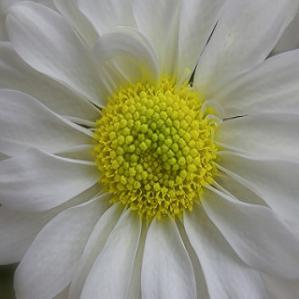

In [ ]:
model_inference('flower-sample', kubeflow_url, tf_request)

In [ ]:
## clean up the previous examples
!kubectl delete inferenceservice --all

## 3. KFServing with Kubeflow Pipeline

In [ ]:
import kfp.dsl as dsl
import kfp
from kfp import components
import json

cookie="authservice_session=" + session

# Create kfp client
# Note: Add the KubeFlow Pipeline endpoint below if the client is not running on the same cluster.
# either use internal or external URL
client = kfp.Client(host=f'http://169.45.121.117:31380/pipeline', cookies=cookie)
EXPERIMENT_NAME = 'KFServing Experiments'
experiment = client.create_experiment(name=EXPERIMENT_NAME, namespace=namespace)

### TensorFlow canary example

In this example, we will be serving two different TensorFlow models that trained on the same [tf_flower](https://www.tensorflow.org/datasets/catalog/tf_flowers) dataset. Then, we deploy both models using canary deployment where user can configure the amount of request traffics on each model. 

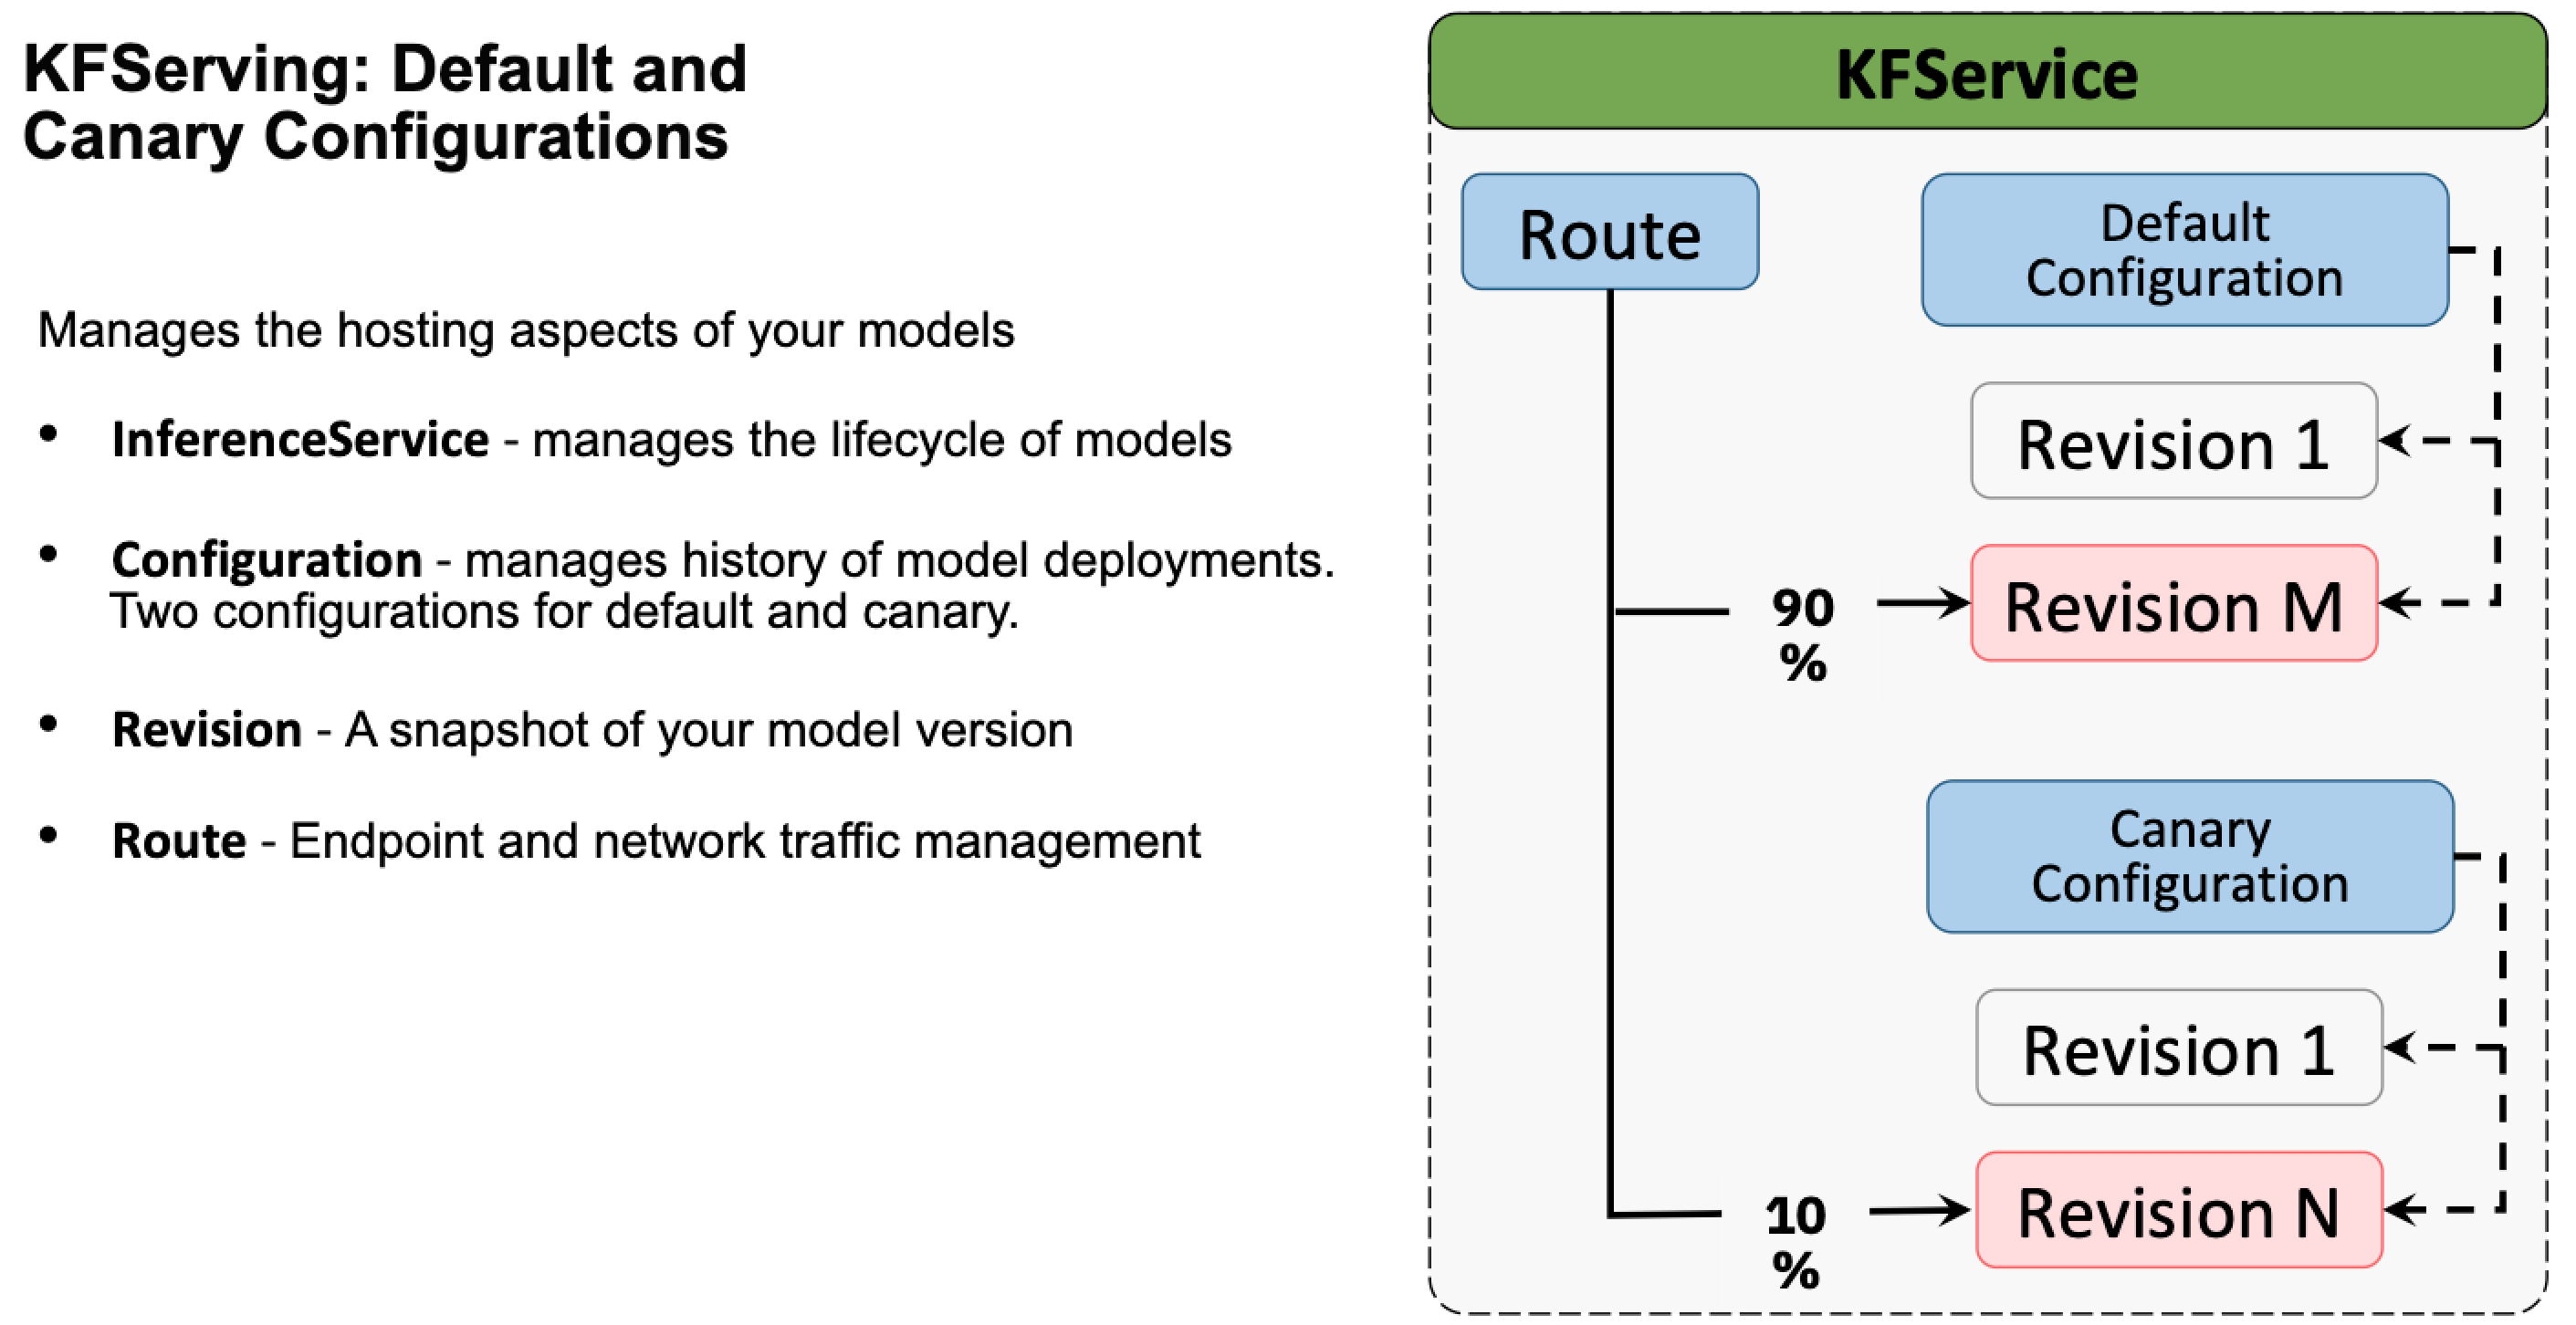

Note: Change the action from `create` to `update` if you are updating an existing model.

In [ ]:
kfserving_op = components.load_component_from_url('https://raw.githubusercontent.com/kubeflow/pipelines/master/components/kubeflow/kfserving/component.yaml')
model_name="tf-flower"
@dsl.pipeline(
  name='kfserving pipeline',
  description='A pipeline for kfserving.'
)
def kfservingPipeline(
    action = 'apply',
    model_name=model_name,
    default_model_uri='gs://kfserving-samples/models/tensorflow/flowers',
    canary_model_uri='gs://kfserving-samples/models/tensorflow/flowers-2',
    canary_model_traffic_percentage='10',
    namespace=namespace,
    framework='tensorflow',
    default_custom_model_spec='{}',
    canary_custom_model_spec='{}',
    autoscaling_target='0',
    kfserving_endpoint=''
):

    # define workflow
    kfserving = kfserving_op(action = action,
                             model_name=model_name,
                             default_model_uri=default_model_uri,
                             canary_model_uri=canary_model_uri,
                             canary_model_traffic_percentage=canary_model_traffic_percentage,
                             namespace=namespace,
                             framework=framework,
                             default_custom_model_spec=default_custom_model_spec,
                             canary_custom_model_spec=canary_custom_model_spec,
                             autoscaling_target=autoscaling_target,
                             kfserving_endpoint=kfserving_endpoint).set_image_pull_policy('Always')

# Compile pipeline
import kfp.compiler as compiler
compiler.Compiler().compile(kfservingPipeline, 'tf-flower.tar.gz')

# Execute pipeline
run = client.run_pipeline(experiment.id, 'tf-flower', 'tf-flower.tar.gz')

### Test model inferencing once it's ready

In [ ]:
model_inference(model_name, kubeflow_url, tf_request)

### Infinite loop for generating inference traffics 

Here we will be generating traffics to our model, then using kiali, a istio monitoring tool, to visualize how the models are interacting with the incoming requests.

In [ ]:
while True:
    model_inference(model_name, kubeflow_url, tf_request)

## Promote the canary model to default model

Once we are satisfy with the canary model, we can promote the canary version to be the default and route 100% of the traffics to it.

In [ ]:
KFServing.promote('tf-flower')

In [ ]:
KFServing.get('tf-flower', watch=True, timeout_seconds=120)

In [ ]:
## clean up the previous examples
!kubectl delete inferenceservice --all

## 4. KFServing Transformer (Preprocessor, Postprocessor)

### Predict on a InferenceService using PyTorch Server and Transformer

This example showcase how to preprocess/postprocess the cifar10 inputs and outputs using the KFServing transformer. Transformer is a service we orchestrated from InferenceService spec for user implemented pre/post processing code. Please visit the original [Example link](https://github.com/kubeflow/kfserving/tree/master/docs/samples/transformer/image_transformer) for more details on the implementation.

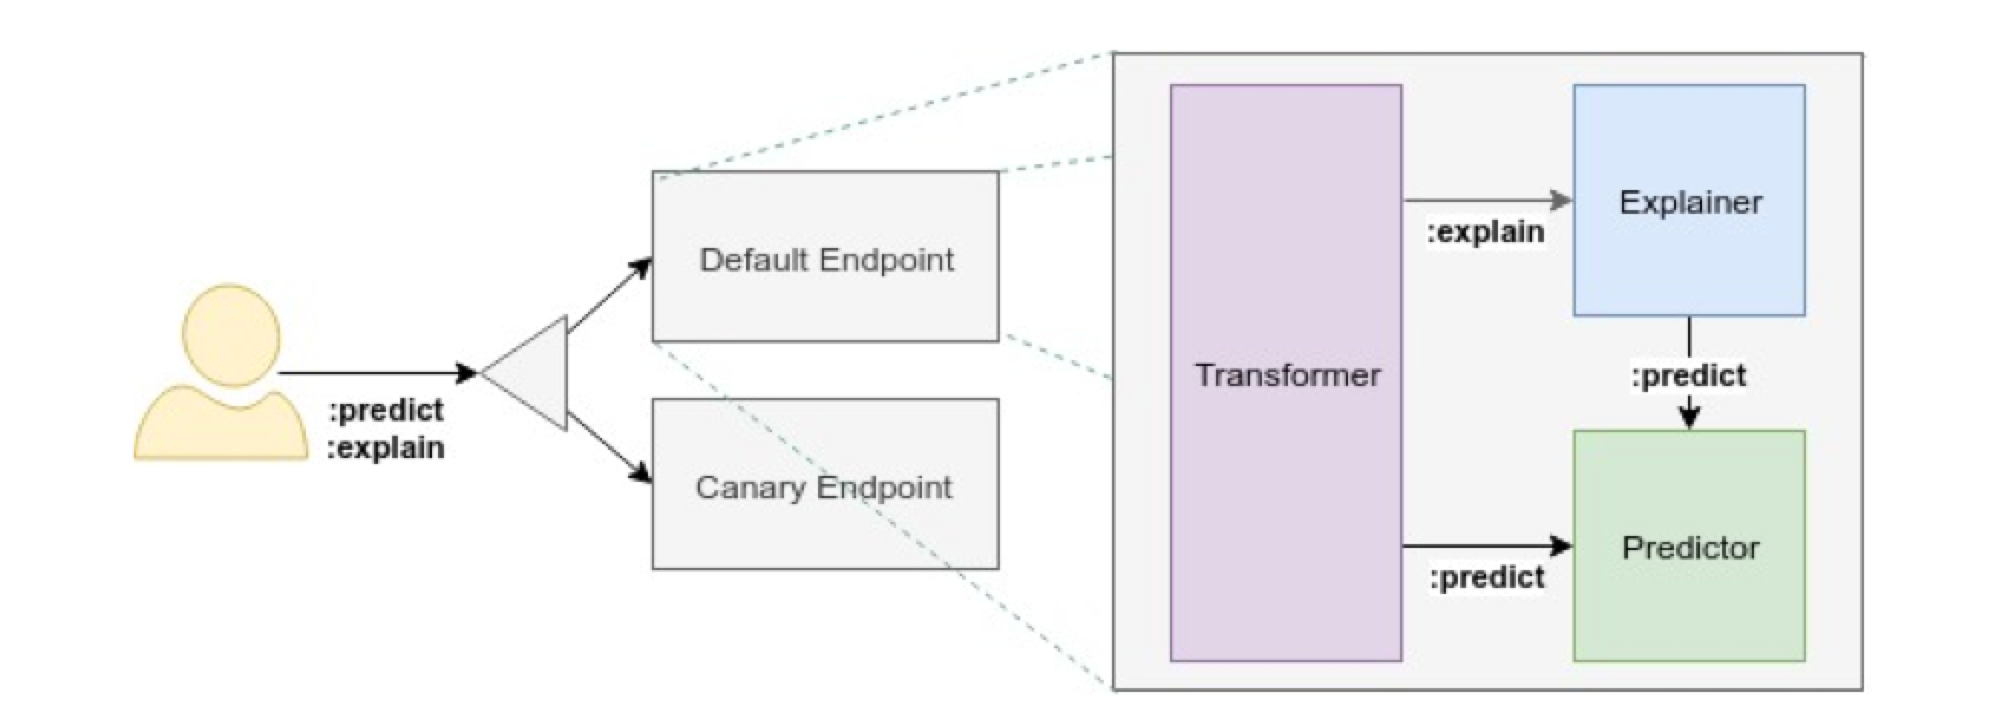

In [ ]:
# annotations is required for multi-user

import textwrap
transformer_yaml = textwrap.dedent("""\
apiVersion: serving.kubeflow.org/v1alpha2
kind: InferenceService
metadata:
  name: transformer-cifar10
  annotations:
    sidecar.istio.io/inject: "false"
spec:
  default:
    predictor:
      pytorch:
        modelClassName: Net
        resources:
          limits:
            cpu: 100m
            memory: 1Gi
          requests:
            cpu: 100m
            memory: 1Gi
        storageUri: gs://kfserving-samples/models/pytorch/cifar10
    transformer:
      custom:
        container:
          image: gcr.io/kubeflow-ci/kfserving/image-transformer:latest
          name: user-container
          resources:
            limits:
              cpu: 100m
              memory: 1Gi
            requests:
              cpu: 100m
              memory: 1Gi
""")
f = open("transformer.yaml", "w")
f.write(transformer_yaml)
f.close()

In [ ]:
!kubectl apply -f transformer.yaml

Wait until the transformer inferenceservice is ready

In [ ]:
!kubectl get pod | grep transformer-cifar10
!kubectl get inferenceservice

### model inferencing

We will be using this sample **cat** image for our inferencing payload.
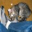

In [ ]:
cifar10_request = {  
    "instances":[  
       {  
          "image_bytes":{
              "b64": "iVBORw0KGgoAAAANSUhEUgAAACAAAAAgCAIAAAD8GO2jAAAJhElEQVR4nAXBWW+c13kA4HPes3z7zPfNDGchqaEoyZLqKonj2E5r2GkCJIDj3vSiF73sT+jvCRAjl4GTNAhQB0WRGEjRyI53ubUWmhVFi+QMOfvybWd5T56HvvNv36UOpeAUQKnaWC2ltIgOHQULjDgdUWKFrBjhFJxFow0iUkK5sbRGSglBh5RSpbS1nDoEYhVibkihLFcEnCsJokciIIxzC0CII1RArZRBxh0wRjgQipqYGohFZIr6lnkKmbJA0VI0vgBOAbizWhNqHLGOUMaAOzTE1c4aahlqxQKgBBkjiFYKYZxAzRCtMZY6Bw4ok475pfXGM50rt91q5mziM0mxEQaBZxAUEMoYE4RodJzbmjAHqD1mCKcEABgQRww6AlTIoH/99no5nc4KwSUQTxleuuDR6dR5Lc0iFfvb1fz8ahl73I6Xw55sJ57POXVGUmKd5YRQylNKqXEIYJRRknnWWoeWUCoFfP/HP/n0/gcXy1luuLHR6dnk5PzcSwf7vUPnJYp7It4x1XZ2dRGmrbPtZYXYS0QomNUFOMJrSFZFaE2dxabBLHcOjaKOODTAoCgW7//H7y6X9eUWTs8Xp6PnzI8ta0SNjghj7gceBR+iqSoH+8OqzE9OLueritH4+k4sLFJrYFKycZn+5k+P/3w0qoALwalzjIGUghKkYE9OT87GMyczFu9BthsMrsl2W1FsZFF/JxZmXS4uEolpJFVViqQ7yeH55aaqCaOcoAPePCxorOXOvEgK5VvnrDOIBsDTtjHO4/ONpXEr611P271Op5vEaZK0VK2r7TqL/Fhyq0pn1Go+I2jLPGcyvFqb0aqynAEncOfbr/EgiZs7r/39W2GyqwxFJlBGCrKke+986ovo2t7BvTjeEcLHWpfr3FnCKP/qwZejs7MwiqIwns3mi+WKUsiSwON8sdUn45VmPpWSh832wY3bpSbDw1sd7ZYnp9oZa8LXfvBPwxuvHH7r2aefP8ji/sXVlDvpCUEc2eb5ajHPIuEIseg6Ozu1NtPFijJI4ogzrqri6fOznTR4YT8B5sUXl5OXvvdq1GwzL7TGMeCnzzcyOyThfhJ1fR4HMvSlR9Du7Q6qqpBSrjebZta+fffFRqPZ7fUpMAoszVqcUcYgCFMqW8fPN2dXOQi/UVWqrrWQYRg1Ij9oCB5z+4uf/fyrh0eT6Vh6AGAOb+wFEVhT9rsdzqFW6satWzdv3WZClFW1zgtjsSyrNG16vt9I242sy4LsbDQFykSxzauiFMLb5JawQBAcpGx6fnxxdnx6fnRy9oQKu3fQ3x32pGStND0YDuM4GezuLddrbfFyMkNHKeNFWZVlSQmJ4qjVaWXt1DrkBB1zOOi0Q997/8v/zwy+0BK+ZyWvJlfPsF4Mbx4y3wsbWae3P5tvV+vCWrKzs8OFVymjtCmr2lhrrK1qZQy0O11KhaSVR411IRecNeMgTQKKZu2i6YJ2Eh5JYUE/u3jWy5oHt16sNPno00fno0USZ0L4Xx1/QwgggVqZbV6mrZZxdHR5FSVNzlwYhlJ6RM9svux1E2CU9rt9TgCrerB/OFHhku5uWbfZaTUbQvjJ9VsvvvJ3b56fXxVFcXl1NRqPBSf9TFTz03w5bjai+XRyOR6t1yujTegHzGmh5qy46Ee6HVAupdfI+sZyj3u3D4effJqsxS2km96eePjow9f/4V8/uP9hnq+1ml6NnxMCWw2c6AwWe8F6NfnasKzXzaw1ZVlVZZELz+BWV+ddUe7GYW1KHsVR1ukYyiuQftxI0+Y3z8dvvPq31RbDZDI6Pzs+OjJWASP5epW0B6tV0Yz9O7fvffzg8WePn73xw58KGT49Pl5tCiRQlduDXhJEQauVOG6McoCmaLZi5ovCOgIwvLZfVGpVoIiG126+PLoYPXr0uNNu+9Lb2927fnjTUVHWKKNWY+fad199YzKZ3b//QV6Uy9XWk17TjQ7i2Z0BZv6au1lEK9jMRoHQnFYUK4qm02oTYFfz/HScg9+/e+/btTbakuW6SLPeC4c3D3YHs8l0Nl0IL846u/NNNZ6ttxUyPxnsH97sdoZJkALwGrkRaAh/evx0+MLf+KBQldz3fd9PkjhuNO7evfOH//p9sRqHre7x2dW1/eHhnZc9yW8Mh8v54uGjr9HZ86Val7ay3npZdPv738yK1rXmzPMIqqWxjvs1Kv7F8dXw3mtIcmoMQbfebJbLabv10ttv/eil79x9999/SylrNrO93f24kTKTt/p8cKhXgf/5gwejLXWi0ey3OzebjPvW0ScuOh5byWhZVYUhBhk/WgVTmzhRgVo5ZABsd9B98/WXfWEPD/b+8Z//5de/fW86Xo1WWFXHkph5aY5Px0Rp17mTdUMkjlKBfohUautWVvhC+pzmtNBCONT8aAm/+5//femg05dRKPig3x90Gjdv7BOnRpPZO79877MvHtaVMoYQB84q6zUsCE4CQ5mBwOeEOFopcEA59xmiq4whKBAYBaUpbEH+8bOjX73/0deT7da6k6dfX+tlvhBbxd/9z48/f3hRGM/yBgQp8ROIm+ABYbamUFlrra4NqYxzAIxBGMo0EIEQVEZWhNpRmaS83dmZL9xosbz/4LHVB4TInf4+Zd5Hn/zfe+9/UGNIuAcAhBBbK4cO0TrnrKOCc8oYYZIzxhhPkpgBgNPWARJBLPb7zaTR5JwxITxTyWeX6zp/9IOXbwfpYFXhn/7ySeWMNtrzfEQsioIQwiinlBBHPMYpcAKcemEQBJxzrc0mzy262mAz6/QGndjn5WbD0VjiAJmvCLva1p89uXi7cBu3OV9svDg2BavqOgwDLnhV1xQYUCY4d8AdAeH5W22VyYMgcM7VBvNKxWkn3ekro548fizQAkFHHDImEHwr4mdXm3fe/f2j08uTi0leayRO+JJJGSZxI20SSrU2da2cI4wxrQ1jlBJXFtsi31Li0qzV6w+ms/nx8fHp0RNiLW+laVVt8lJJFhiDILz//ujLk4uLVa7n29IoEkWxQfQ8j0vpB5YB40JaAgYdReectVorrQLf77TbWWegHNSSl55ELvKq5HVVekBqqwWThhEHAEF8ejEBzox2xmBVVXmeA4DneZEUQeADoPS9IIyVMtP5HInhArJG1Gul/X5rmdeb5WK7Wqat1nQy5XVZeYyGnKAuKSNIEB0iYUY5Z6lzzjmHiACwWCzmumzEUTNrNRj4xLdYc2qZx+qq9jjl1JpiZYp6u5yhVr4nKsb+CkyFkScvikzRAAAAAElFTkSuQmCC"
          }
       }
    ]
 }
model_inference('transformer-cifar10', kubeflow_url, cifar10_request)

In [ ]:
while True:
    model_inference('transformer-cifar10', kubeflow_url, cifar10_request)

In [ ]:
!kubectl delete inferenceservice --all

### AIX360 on KFServing

This is an example for how to explain model outputs using AIX360 on KFServing. We will be using the mnist, dataset for hand written digits, for this model and explain how the moel decide the predicted results. Please visting the original [example link](https://github.com/drewbutlerbb4/kfserving/tree/master/docs/samples/explanation/aix/mnist) for more details on the implementation.

In [ ]:
# annotations is required for multi-user
import textwrap
aix_yaml = textwrap.dedent("""
apiVersion: serving.kubeflow.org/v1alpha2
kind: InferenceService
metadata:
  labels:
    controller-tools.k8s.io: "1.0"
  annotations:
    sidecar.istio.io/inject: "false"
  name: aixserver
spec:
  default:
    predictor:
      custom:
        container:
          name: predictor
          image: aipipeline/rf-predictor:0.2.2
          command: ["python", "-m", "rfserver", "--model_name", "aixserver"]
          imagePullPolicy: Always
          resources:
            requests:
              memory: "2Gi"
              cpu: "1"
            limits:
              memory: "2Gi"
              cpu: "1"
    explainer:
      custom:
        container:
          name: explainer
          image: aipipeline/aix-explainer:0.2.2
          command: ["python", "-m", "aixserver", "--predictor_host", "aixserver-predictor-default.%s.svc.cluster.local", "explainer_type", "LimeImages"]
          imagePullPolicy: Always
          resources:
            requests:
              memory: "4Gi"
              cpu: "2"
            limits:
              memory: "4Gi"
              cpu: "2"
""" % namespace)
f = open("aix.yaml", "w")
f.write(aix_yaml)
f.close()

Here is a high level workflow of the AIX explainer.
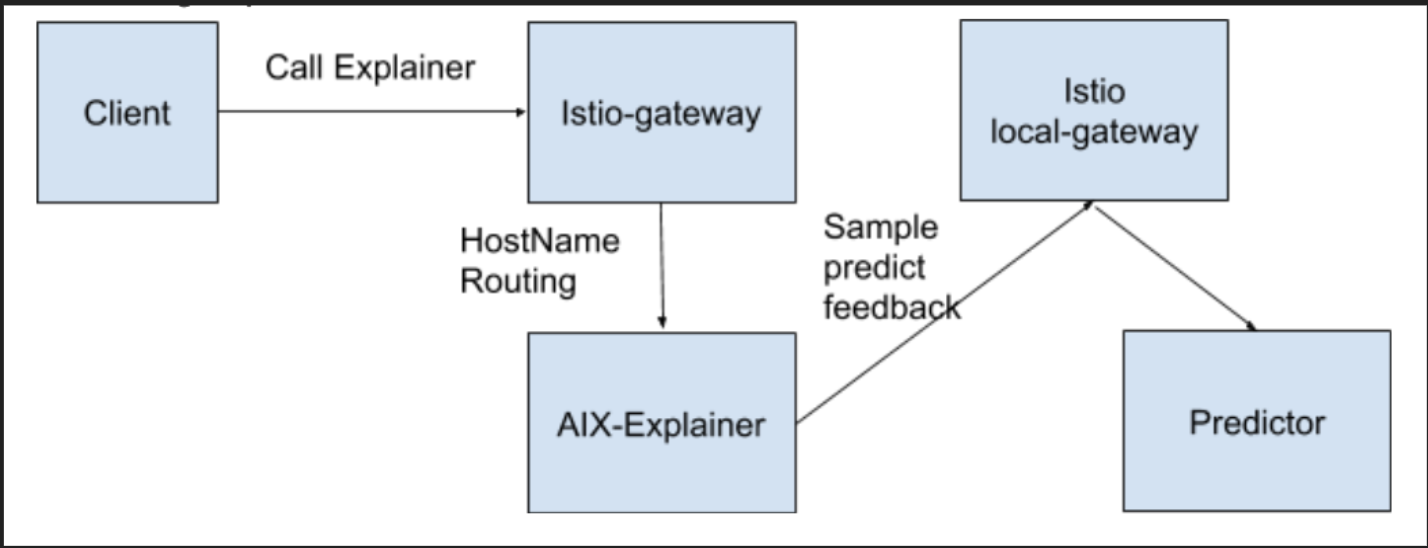

In [ ]:
!kubectl apply -f aix.yaml

Wait until the aixserver inferenceservice is ready

In [ ]:
!kubectl get pod | grep aixserver
!kubectl get inferenceservice

In [ ]:
import os
import sys
import requests
import json
from matplotlib import pyplot as plt
import numpy as np
from keras.datasets import mnist
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
import time
from skimage.color import gray2rgb, rgb2gray, label2rgb # since the code wants color images


test_num = 1002
endpoint = "http://" + kubeflow_url + "/v1/models/aixserver:explain"
headers = {
        'Host': "aixserver.%s.example.com" % namespace,
        'Cookie': cookie
    }

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
inputs = (test_images[test_num] / 255) - 0.5
labels = test_labels[test_num]
actual = test_labels[test_num]
inputs = gray2rgb(inputs.reshape((-1, 28, 28)))
inputs = np.reshape(inputs, (28,28,3))
input_image = {"instances": [inputs.tolist()]}

fig0 = (inputs[:,:,0] + 0.5)*255
f, axarr = plt.subplots(1, 1, figsize=(10,10))
axarr.set_title("Original Image")
axarr.imshow(fig0, cmap="gray")
plt.show()

x = time.time()
res = requests.post(endpoint, json=input_image, headers=headers)

print("TIME TAKEN: ", time.time() - x)
print(res)

res_json = res.json()
temp = np.array(res_json["explanations"]["temp"])
masks = np.array(res_json["explanations"]["masks"])
top_labels = np.array(res_json["explanations"]["top_labels"])

fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    mask = masks[i]
    c_ax.imshow(label2rgb(mask, temp, bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nActual {}'.format(top_labels[i], actual))
    c_ax.axis('off')
plt.show()

In [ ]:
while True:
    requests.post(endpoint, json=input_image, headers=headers)
    print(res)

In [ ]:
!kubectl delete inferenceservice --all

### 6. KFServing Scale Test

The KFServing scale test creates a big amount of traffic and make KFServing to scale up to the Knative autoscale target (default is 100 instances). In order to reach 100% success rate of the performace test, the cluster needs to have at least 32 cpu and 64Gb of memory with fast start time. 100 cpu and 200Gb of memory is recommended if you want see the optimal test result.

First, we need to redeploy the sklearn model and set the autoscale target to 10

In [ ]:
# annotations is required for multi-user

import textwrap
sklearn_yaml = textwrap.dedent("""\
apiVersion: "serving.kubeflow.org/v1alpha2"
kind: "InferenceService"
metadata:
  annotations:
    autoscaling.knative.dev/target: "10"
    sidecar.istio.io/inject: "false"
  name: "sklearn-iris"
spec:
  default:
    predictor:
      sklearn:
        storageUri: "gs://kfserving-samples/models/sklearn/iris"
""")
f = open("sklearn.yaml", "w")
f.write(sklearn_yaml)
f.close()

In [ ]:
!kubectl apply -f sklearn.yaml

Make sure the model is up and running before proceeding to the scale test.

In [ ]:
!kubectl get pod | grep sklearn-iris
!kubectl get inferenceservice sklearn-iris

Run the scale test for 2 minutes

In [ ]:
import textwrap
sklearn_perf_yaml = textwrap.dedent("""
apiVersion: v1
data:
  cfg: |
    POST http://sklearn-iris.%s.svc.cluster.local/v1/models/sklearn-iris:predict
    @/var/vegeta/payload
  payload: |
    {
      "instances": [
        [6.8,  2.8,  4.8,  1.4],
        [6.0,  3.4,  4.5,  1.6]
      ]
    }
kind: ConfigMap
metadata:
  annotations:
  name: vegeta-cfg
---
apiVersion: batch/v1
kind: Job
metadata:
  name: load-test
spec:
  backoffLimit: 6
  parallelism: 1
  template:
    metadata:
      annotations:
        sidecar.istio.io/inject: "false"
    spec:
      restartPolicy: OnFailure
      containers:
      - args:
        - vegeta -cpus=5 attack -duration=2m -rate=500/1s -targets=/var/vegeta/cfg
          | vegeta report -type=text
        command:
        - sh 
        - -c
        image: peterevans/vegeta:latest
        imagePullPolicy: Always
        name: vegeta
        volumeMounts:
        - mountPath: /var/vegeta
          name: vegeta-cfg
      volumes:
      - configMap:
          defaultMode: 420
          name: vegeta-cfg
        name: vegeta-cfg
""" % namespace)
f = open("sklearn_perf.yaml", "w")
f.write(sklearn_perf_yaml)
f.close()

In [ ]:
!kubectl delete -f sklearn_perf.yaml
!kubectl apply -f sklearn_perf.yaml

Run the below command to see how many pods are scaling. You may see many of the pods are in pending stage if your cluster doesn't have enough cpu or memory available for scaling.

In [ ]:
!kubectl get pods

In [ ]:
%%bash
# Get the scale test details
LOAD_TEST_NAME=$(kubectl get pods | grep load-test | awk '{print $1;exit}')
kubectl logs ${LOAD_TEST_NAME}  -f

# Clean up

In [ ]:
!kubectl delete inferenceservice --all
!kubectl delete job --all
!kubectl delete cm vegeta-cfg